In [1]:
import os 
import time
import uuid
import cv2
import tensorflow as tf

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 10
print(IMAGES_PATH)

data\images


In [28]:
current_object = 0

In [33]:
#capturing images module 
cap = cv2.VideoCapture(0)

item_list = ['phone', 'cup', 'notebook', 'pen', 'keyboard']
time.sleep(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    
    ret, frame = cap.read()
    name = f'{item_list[current_object]}_{imgnum + 1}'
    imgname = os.path.join(IMAGES_PATH,f'{name}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
current_object += 1
print(current_object)

5


In [35]:
#labeling our data 
!labelme

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt


In [3]:
#setting gpu memory growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#loading images in a tensorflow pipline using the wildcard format *.jpg
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [95]:
print(len(images))

50


In [6]:
#function to load images to the tf pipline 
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

In [130]:
image_generator = images.batch(4).as_numpy_iterator()

In [132]:
plot_images = image_generator.next()

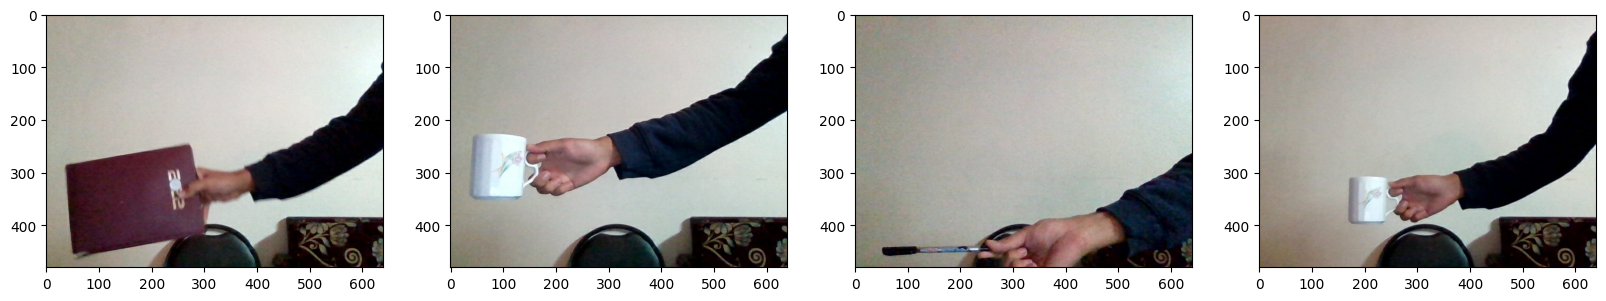

In [133]:
#Plotting some of the loaded data 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [141]:
dir = os.path.dirname('C:\\Users\\adham\\Desktop\\AI_Project_v1\\data\\train\\images')
list = os.listdir(os.path.join(dir,'images'))
print(len(list))

30


In [142]:
#moving the labels to the new directories 
#we mannualy split data to different directories 
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

In [7]:
#image augmentation
import albumentations as alb

In [144]:
#building the augmentor which will apply random formatting on our images 
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [153]:
#testing augmenation on one image for starters 
img = cv2.imread(os.path.join('data', 'train', 'images', 'cup_2.jpg'))

In [ ]:
img.shape

In [ ]:
os.listdir()

In [156]:
with open(os.path.join('data', 'train', 'labels', 'cup_2.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label

In [183]:
class_type = label['shapes'][0]['label']
print(class_type)

cup


In [169]:
#extracting coordinations 
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

In [172]:
coords = np.divide(coords, [640,480,640,480])

In [175]:
type(coords)

numpy.ndarray

In [176]:
coords = coords.tolist()

In [177]:
coords

[0.11371527777777772,
 0.6056134259259259,
 0.2862413194444444,
 0.8645833333333334]

In [178]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['cup'])

In [184]:
augmented['class_labels']

['cup']

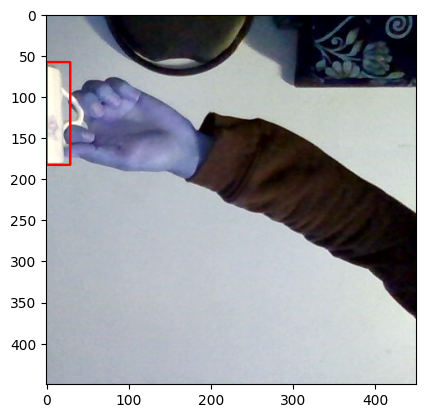

In [182]:
#plotting the image and selecting the rectangle containing the object 
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [ ]:
#run augmenatino pipeline 
#setting classes for each photo 
# [cup => 1, keyboard =>2, pen => 3, notebook => 4, phone => 5]
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        print(img)
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = np.divide(coords, [640,480,640,480])
            coords = coords.tolist()
            class_type = label['shapes'][0]['label']

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_type])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        object_class = augmented['class_labels']
                        # annotation['class'] = 1
                        # annotation['class'] = augmented['class_labels']

                        if (object_class == ["cup"]):
                            annotation['class'] = 1
                        
                        if (object_class == ["keyboard"]):
                            annotation['class'] = 2
                        
                        if (object_class == ["pen"]):
                            annotation['class'] = 3
                        
                        if (object_class == ["notebook"]):
                            annotation['class'] = 4
                        
                        if (object_class == ["phone"]):
                            annotation['class'] = 5
                        
                            
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [8]:
#preprocessing images for the model 
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [9]:
#preprocessing test images 
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [10]:
#preprocessing validation images
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

In [12]:
#function to load our json lables from the files 
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [13]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

In [18]:
#batching our data
#prefectch helps the model to pick images from the pipeline 
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(1)
train = train.prefetch(4)

In [19]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(1)
test = test.prefetch(4)

In [20]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(1)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

In [22]:
data_samples = train.as_numpy_iterator()

In [23]:
res = data_samples.next()

In [ ]:
#Plotting some of the images 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [26]:
#downloading VGG16 and setting the output layer to false 
# because we want to use our own classification functions 
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

In [ ]:
train.as_numpy_iterator().next()[1]

In [114]:
#our model is using the functional API of tensorflow 
#becuase for each sample we want to predict two different things 
#first we want the coordinates of the shape ----> regression task 
#secondly we want to predict the class of the shape -----> classification task 
#so we built the model that way 


def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(6, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='tanh')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    classifier = Model(inputs=input_layer, outputs=[class2, regress2])
    return classifier

In [115]:
classifier = build_model()

In [116]:
classifier.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [117]:
X, y = train.as_numpy_iterator().next()

In [118]:
X.shape

(1, 120, 120, 3)

In [119]:
classes, coords = classifier.predict(X)

1/1 [==============================] - 0s 312ms/step


In [120]:
classes

array([[0.09743544, 0.12624174, 0.24534574, 0.09108752, 0.37761667,
        0.06227291]], dtype=float32)

In [121]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [122]:
#choosing our optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [123]:
#custom loss function for the coordinates task 
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [124]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy()
regressloss = localization_loss

In [ ]:
localization_loss(y[1], coords)

In [ ]:
classloss(y[0][0], classes)


In [41]:
print(classes[0])

[0.14247084 0.19055355 0.11515591 0.19811906 0.23257335 0.1211273 ]


In [ ]:
regressloss(y[1], coords)

In [127]:
#Building the model 
class Classifier(Model): 
    def __init__(self, classifier,  **kwargs): 
        super().__init__(**kwargs)
        self.model = classifier

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0][0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0][0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [128]:
model = Classifier(classifier)

In [129]:
model.compile(opt, classloss, regressloss)

In [130]:
logdir='logs'

In [131]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [132]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
1200/1200 [==============================] - 42s 30ms/step - total_loss: 0.6627 - class_loss: 0.9796 - regress_loss: 0.1729 - val_total_loss: 0.1701 - val_class_loss: 0.0532 - val_regress_loss: 0.1435
Epoch 2/10
1200/1200 [==============================] - 39s 31ms/step - total_loss: 0.1265 - class_loss: 0.1277 - regress_loss: 0.0626 - val_total_loss: 0.1340 - val_class_loss: 0.0036 - val_regress_loss: 0.1322
Epoch 3/10
1200/1200 [==============================] - 38s 30ms/step - total_loss: 0.0512 - class_loss: 0.0388 - regress_loss: 0.0318 - val_total_loss: 0.9365 - val_class_loss: 1.7310 - val_regress_loss: 0.0709
Epoch 4/10
1200/1200 [==============================] - 39s 31ms/step - total_loss: 0.0226 - class_loss: 0.0153 - regress_loss: 0.0149 - val_total_loss: 0.1647 - val_class_loss: 3.3147e-04 - val_regress_loss: 0.1645
Epoch 5/10
1200/1200 [==============================] - 38s 31ms/step - total_loss: 0.0297 - class_loss: 0.0228 - regress_loss: 0.0183 - val_total_l

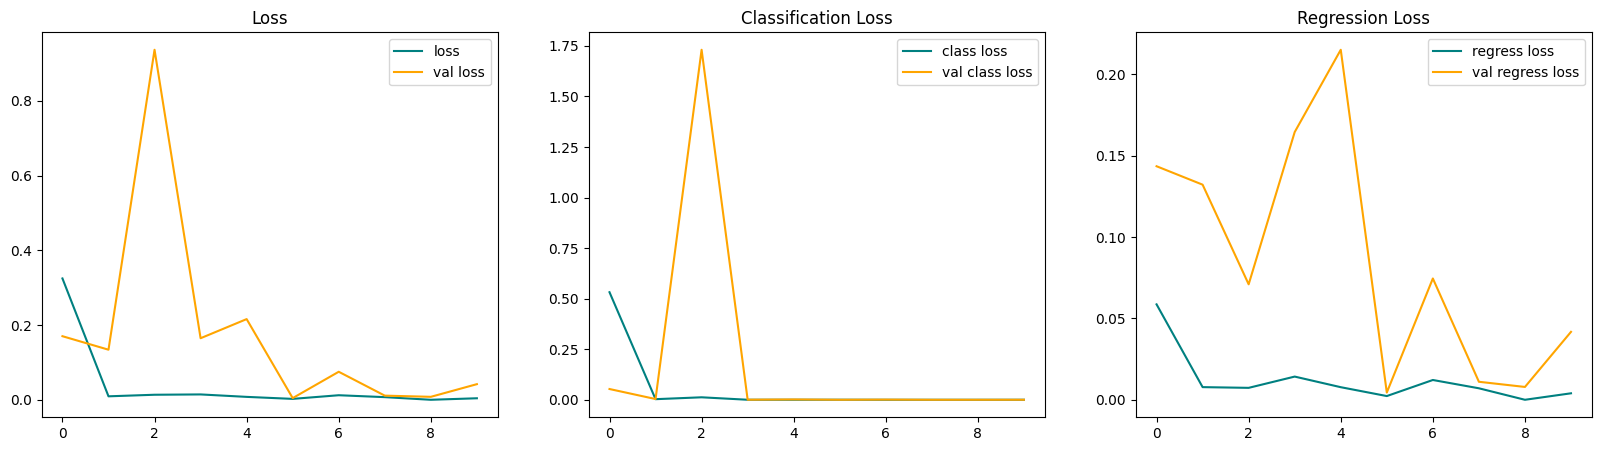

In [133]:
#plotting and evaluating the model performance 
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


In [283]:
test_data = test.as_numpy_iterator()

In [304]:
test_sample = test_data.next()

In [305]:
yhat = classifier.predict(test_sample[0])
test_sample[0].shape

1/1 [==============================] - 0s 35ms/step


(1, 120, 120, 3)

In [306]:
print(yhat[1])

[[0.06148317 0.04883232 0.28235346 0.3572857 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


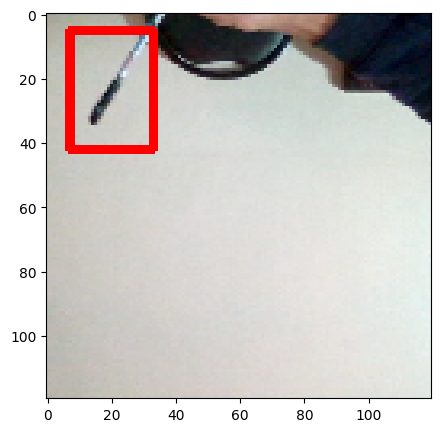

In [307]:
fig, ax = plt.subplots(figsize=(5,5))
 
sample_image = np.squeeze(test_sample[0])
sample_coords = yhat[1]


cv2.rectangle(sample_image, 
            tuple(np.multiply(sample_coords[0][:2], [120,120]).astype(int)),
            tuple(np.multiply(sample_coords[0][2:], [120,120]).astype(int)), 
                    (255,0,0), 2)
    

ax.imshow(sample_image)

In [309]:
#predicting the class of the object  
objects = ['none', 'cup', 'keyboard', 'pen', 'notebook', 'phone']
print(objects[np.argmax(yhat[0])])

pen


In [292]:
#saving the model 
classifier.save('ob_detection.h5')